In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [2]:
cwd = os.getcwd()

def make_dir(path):
    if os.path.exists(path) is False:
        os.makedirs(path)

def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    print('MAE: {:.2f}'.format(mae))
    print('RMSE: {:.2f}'.format(rmse))
    print('')
    print('')
    return mae, rmse

In [3]:
sl = pd.read_csv('dataset/SCED (5m).csv')
sl['sced_time_stamp_local'] = pd.to_datetime(sl['sced_time_stamp_local'])
sl.set_index('sced_time_stamp_local', inplace=True)
sl = sl.resample('h').mean()
date_range = pd.date_range(start=sl.index.min(), end=sl.index.max(), freq='h')
sl = sl[~sl.index.duplicated(keep='first')]
sl = sl.reindex(date_range, fill_value=np.nan)
sl.interpolate(method='time', inplace=True)


In [4]:
dap = pd.read_csv('dataset/DAP (1hr).csv')
dap['timestamp'] = pd.to_datetime(dap['timestamp'])
dap.set_index('timestamp', inplace=True)
date_range = pd.date_range(start=dap.index.min(), end='2024-01-01 23:55:00', freq='h')
dap = dap[~dap.index.duplicated(keep='first')]
dap = dap.reindex(date_range, fill_value=np.nan)
dap.interpolate(method='time', inplace=True)

/var/folders/kv/ldp2ch2s1md4v31v75w2dt2c0000gn/T/ipykernel_83258/1171035437.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dap['timestamp'] = pd.to_datetime(dap['timestamp'])


In [5]:
current_load = pd.read_csv('dataset/Load (5m).csv')
current_load['interval_start_local'] = pd.to_datetime(current_load['interval_start_local'])
current_load.set_index('interval_start_local', inplace=True)
date_range = pd.date_range(start=current_load.index.min(), end='2024-01-01 23:55:00', freq='h')
current_load = current_load[~current_load.index.duplicated(keep='first')]
current_load = current_load.reindex(date_range, fill_value=np.nan)
current_load.interpolate(method='time', inplace=True)


In [6]:
current_fuel = pd.read_csv('dataset/Fuel (5m).csv')
current_fuel['interval_start_local'] = pd.to_datetime(current_fuel['interval_start_local'])
current_fuel.set_index('interval_start_local', inplace=True)
date_range = pd.date_range(start=current_fuel.index.min(), end='2024-01-01 23:55:00', freq='h')
current_fuel = current_fuel[~current_fuel.index.duplicated(keep='first')]
current_fuel = current_fuel.reindex(date_range, fill_value=np.nan)
current_fuel.interpolate(method='time', inplace=True)

In [7]:
# Combine into one DataFrame
fuel_share_df = current_fuel.copy()
fuel_share_df['load'] = current_load['load']

# Avoid divide-by-zero or NaNs
fuel_share_df = fuel_share_df.dropna(subset=['load'])
fuel_share_df = fuel_share_df[fuel_share_df['load'] != 0]

# Calculate % share of each generation type
for col in current_fuel.columns:
    fuel_share_df[f"{col}_share"] = fuel_share_df[col] / fuel_share_df['load']

# Optional: Keep only the share columns
generation_share_df = fuel_share_df[[col for col in fuel_share_df.columns if col.endswith('_share')]]


In [8]:
generation_share_df

,coal_and_lignite_share,hydro_share,nuclear_share,power_storage_share,solar_share,wind_share,natural_gas_share,other_share
2019-01-01 00:00:00,0.165528,0.005019,0.105436,0.000000,0.0,0.387307,0.338632,0.000069
2019-01-01 01:00:00,0.173077,0.005030,0.104952,0.000000,0.0,0.385280,0.335044,0.000079
2019-01-01 02:00:00,0.169814,0.005044,0.104827,0.000000,0.0,0.377640,0.344438,-0.000053
2019-01-01 03:00:00,0.172107,0.005038,0.104464,0.000000,0.0,0.365049,0.356168,0.000051
2019-01-01 04:00:00,0.173720,0.004945,0.102936,0.000000,0.0,0.354712,0.359237,-0.000005
...,...,...,...,...,...,...,...,...
2024-01-01 19:00:00,0.142630,0.000000,0.121998,0.002163,0.0,0.401681,0.336713,0.000000
2024-01-01 20:00:00,0.142630,0.000000,0.121998,0.002163,0.0,0.401681,0.336713,0.000000
2024-01-01 21:00:00,0.142630,0.000000,0.121998,0.002163,0.0,0.401681,0.336713,0.000000
2024-01-01 22:00:00,0.142630,0.000000,0.121998,0.002163,0.0,0.401681,0.336713,0.000000


In [9]:
forecasted_tlf = pd.read_csv('dataset/FORECASTED_TLF (15m).csv')
forecasted_tlf['datetime'] = pd.to_datetime(forecasted_tlf['datetime'])
forecasted_tlf.set_index('datetime', inplace=True)
date_range = pd.date_range(start=forecasted_tlf.index.min(), end='2024-01-01 23:55:00', freq='h')
forecasted_tlf = forecasted_tlf[~forecasted_tlf.index.duplicated(keep='first')]
forecasted_tlf = forecasted_tlf.reindex(date_range, fill_value=np.nan)
forecasted_tlf.interpolate(method='time', inplace=True)


In [10]:
# Read the CSV file for natural gas prices
ng_price = pd.read_csv('dataset/NaturalGasPrice (1D).csv')

# Convert the 'datetime' column to datetime objects
ng_price['datetime'] = pd.to_datetime(ng_price['Date'])

# Set the 'datetime' column as the index
ng_price.set_index('datetime', inplace=True)

# Create an hourly date range from the minimum datetime up to '2024-01-01 23:55:00'
date_range = pd.date_range(start=ng_price.index.min(), end='2024-01-01 23:55:00', freq='h')

# Remove duplicated datetime entries, keeping the first occurrence
ng_price = ng_price[~ng_price.index.duplicated(keep='first')]

# Reindex the DataFrame to the hourly date range, filling missing entries with NaN
ng_price = ng_price.reindex(date_range, fill_value=np.nan)

# Interpolate missing values using time-based interpolation
ng_price.interpolate(method='time', inplace=True)
ng_price.drop(columns=['Date'], inplace=True)
ng_price

/var/folders/kv/ldp2ch2s1md4v31v75w2dt2c0000gn/T/ipykernel_83258/2646805775.py:20: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  ng_price.interpolate(method='time', inplace=True)


,Henry Hub Natural Gas Spot Price (Dollars per Million Btu)
1997-01-07 00:00:00,3.820000
1997-01-07 01:00:00,3.819167
1997-01-07 02:00:00,3.818333
1997-01-07 03:00:00,3.817500
1997-01-07 04:00:00,3.816667
...,...
2024-01-01 19:00:00,2.580000
2024-01-01 20:00:00,2.580000
2024-01-01 21:00:00,2.580000
2024-01-01 22:00:00,2.580000


In [11]:
# Prepare final dataframe
df = pd.concat([dap, sl, forecasted_tlf, current_load, ng_price, generation_share_df], axis=1)

# Rename columns (adding Natural Gas at the end)
df.columns = ['DAP', 'SCED', 'F_TLF', 'Load', 'NG Price', 'Coal', 'Hydro', 'Nuclear',
              'Power Storage', 'Solar', 'Wind', 'Natural Gas', 'Other']

df.dropna(inplace=True)

df

,DAP,SCED,F_TLF,Load,NG Price,Coal,Hydro,Nuclear,Power Storage,Solar,Wind,Natural Gas,Other
2019-01-02 00:00:00,23.9250,26.216109,0.016499,39277.0,3.250000,0.280547,0.005393,0.099076,0.000000,0.0,0.065089,0.556491,0.000020
2019-01-02 01:00:00,23.3140,25.671136,0.016441,38589.0,3.227917,0.269215,0.004876,0.100835,0.000000,0.0,0.062654,0.562985,0.000032
2019-01-02 02:00:00,23.3475,24.970952,0.016411,38431.0,3.205833,0.264073,0.004878,0.101243,0.000000,0.0,0.070083,0.557090,-0.000064
2019-01-02 03:00:00,23.0595,24.787712,0.016441,38828.0,3.183750,0.253581,0.004830,0.100222,0.000000,0.0,0.080581,0.551877,-0.000037
2019-01-02 04:00:00,25.2672,24.887786,0.016534,40043.0,3.161667,0.245480,0.004699,0.097198,0.000000,0.0,0.082141,0.553191,-0.000079
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00,19.3715,14.422107,0.021356,45324.0,2.580000,0.161402,0.000384,0.112859,0.000373,0.0,0.350569,0.377493,0.000000
2023-12-31 20:00:00,16.7739,12.597410,0.021367,44309.0,2.580000,0.135257,0.000404,0.115437,0.005263,0.0,0.400548,0.341511,0.000000
2023-12-31 21:00:00,15.0035,10.170172,0.021383,43517.0,2.580000,0.138507,0.000000,0.117510,0.001098,0.0,0.432249,0.314153,0.000000
2023-12-31 22:00:00,15.7699,9.872549,0.021408,42678.0,2.580000,0.139826,0.000000,0.119832,0.000403,0.0,0.437834,0.308749,0.000000


In [12]:

import holidays

# Get official Texas holidays
tx_holidays = holidays.US(state='TX')  # includes state + federal holidays observed in Texas

# Add holiday indicator to your DataFrame (assumes datetime index)
df['is_holiday'] = df.index.to_series().apply(lambda x: 1 if x.date() in tx_holidays else 0)


df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek

df

,DAP,SCED,F_TLF,Load,NG Price,Coal,Hydro,Nuclear,Power Storage,Solar,Wind,Natural Gas,Other,is_holiday,hour,dayofweek
2019-01-02 00:00:00,23.9250,26.216109,0.016499,39277.0,3.250000,0.280547,0.005393,0.099076,0.000000,0.0,0.065089,0.556491,0.000020,0,0,2
2019-01-02 01:00:00,23.3140,25.671136,0.016441,38589.0,3.227917,0.269215,0.004876,0.100835,0.000000,0.0,0.062654,0.562985,0.000032,0,1,2
2019-01-02 02:00:00,23.3475,24.970952,0.016411,38431.0,3.205833,0.264073,0.004878,0.101243,0.000000,0.0,0.070083,0.557090,-0.000064,0,2,2
2019-01-02 03:00:00,23.0595,24.787712,0.016441,38828.0,3.183750,0.253581,0.004830,0.100222,0.000000,0.0,0.080581,0.551877,-0.000037,0,3,2
2019-01-02 04:00:00,25.2672,24.887786,0.016534,40043.0,3.161667,0.245480,0.004699,0.097198,0.000000,0.0,0.082141,0.553191,-0.000079,0,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00,19.3715,14.422107,0.021356,45324.0,2.580000,0.161402,0.000384,0.112859,0.000373,0.0,0.350569,0.377493,0.000000,0,19,6
2023-12-31 20:00:00,16.7739,12.597410,0.021367,44309.0,2.580000,0.135257,0.000404,0.115437,0.005263,0.0,0.400548,0.341511,0.000000,0,20,6
2023-12-31 21:00:00,15.0035,10.170172,0.021383,43517.0,2.580000,0.138507,0.000000,0.117510,0.001098,0.0,0.432249,0.314153,0.000000,0,21,6
2023-12-31 22:00:00,15.7699,9.872549,0.021408,42678.0,2.580000,0.139826,0.000000,0.119832,0.000403,0.0,0.437834,0.308749,0.000000,0,22,6


In [13]:
## log transform
log_data = df.copy(deep=True)

columns_to_log = ['DAP', 'SCED', 'F_TLF', 'Load']

for col in columns_to_log:
    min_val = log_data[col].min()
    log_data[col] = np.log(log_data[col] - min_val + 1)


# 3 years training, 1 year validation, 1 year testing
x_train_df_reg = log_data.loc[:'2021-12-31 23:55:00'].iloc[:, :]
x_val_df_reg = log_data.loc['2022-01-01 00:00:00':'2022-12-31 23:55:00'].iloc[:, :]
x_test_df_reg = log_data.loc['2023-01-01 00:00:00':].iloc[:, :]

# Change target variable to DAP
y_train_df_reg = log_data.loc[:'2021-12-31 23:55:00'].iloc[:, :1]
y_val_df_reg = log_data.loc['2022-01-01 00:00:00':'2022-12-31 23:55:00'].iloc[:, :1]
y_test_df_reg = log_data.loc['2023-01-01 00:00:00':].iloc[:, :1]

x_train_df_reg.reset_index(drop=True, inplace=True)
x_val_df_reg.reset_index(drop=True, inplace=True)
x_test_df_reg.reset_index(drop=True, inplace=True)

# Standardization
x_mean_reg, x_std_reg = x_train_df_reg.mean(), x_train_df_reg.std()
y_mean_reg, y_std_reg = y_train_df_reg.mean(), y_train_df_reg.std()

x_std_reg = x_std_reg + 0.00001

x_train_reg = (x_train_df_reg - x_mean_reg) / x_std_reg
x_val_reg = (x_val_df_reg - x_mean_reg) / x_std_reg
x_test_reg = (x_test_df_reg - x_mean_reg) / x_std_reg

y_train_reg = (y_train_df_reg - y_mean_reg) / y_std_reg
y_val_reg = (y_val_df_reg - y_mean_reg) / y_std_reg
y_test_reg = (y_test_df_reg - y_mean_reg) / y_std_reg

# Shift the data for the lags
n_steps_in = 24
n_steps_out = 24

x_train_lstm = np.array([x_train_reg[i:i+n_steps_in] for i in range(0, x_train_reg.shape[0]-n_steps_in-n_steps_out+1)])
y_train_lstm = np.array([y_train_reg[i+n_steps_in:i+n_steps_in+n_steps_out] for i in range(0, y_train_reg.shape[0]-n_steps_in-n_steps_out+1)])

x_val_lstm = np.array([x_val_reg[i:i+n_steps_in] for i in range(0, x_val_reg.shape[0]-n_steps_in-n_steps_out+1)])
y_val_lstm = np.array([y_val_reg[i+n_steps_in:i+n_steps_in+n_steps_out] for i in range(0, y_val_reg.shape[0]-n_steps_in-n_steps_out+1)])

x_test_lstm = np.array([x_test_reg[i:i+n_steps_in] for i in range(0, x_test_reg.shape[0]-n_steps_in-n_steps_out+1)])
y_test_lstm = np.array([y_test_reg[i+n_steps_in:i+n_steps_in+n_steps_out] for i in range(0, y_test_reg.shape[0]-n_steps_in-n_steps_out+1)])

print(x_train_lstm.shape, y_train_lstm.shape, x_val_lstm.shape, y_val_lstm.shape, x_test_lstm.shape, y_test_lstm.shape)


(26233, 24, 16) (26233, 24, 1) (8713, 24, 16) (8713, 24, 1) (8713, 24, 16) (8713, 24, 1)


In [14]:
y_train_lstm = y_train_lstm.squeeze(-1)
y_val_lstm = y_val_lstm.squeeze(-1)
y_test_lstm = y_test_lstm.squeeze(-1)

In [15]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create a directory for saving the model if it doesn't exist
model_dir = os.path.join(os.getcwd(), 'saved_model')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

In [16]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_rate=0.3):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True, dropout=dropout_rate)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first=True, dropout=dropout_rate)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm1(x)
        out, _ = self.lstm2(out)
        out = out[:, -1, :]        # take output from last time step
        out = self.dropout(out)    # apply dropout before dense layers
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [17]:
# Set hyperparameters (same as before)
n_neurons = 64
learning_rate = 0.0005
batch_size = 64
num_epochs = 50
patience = 15  # for early stopping

input_size = x_train_lstm.shape[2]  # number of features
output_size = y_train_lstm.shape[1]  # number of time steps out (24)

# Initialize model, loss function, and optimizer
model = LSTMModel(input_size, n_neurons, output_size, dropout_rate=0.3).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Prepare DataLoaders
train_dataset = TensorDataset(torch.tensor(x_train_lstm, dtype=torch.float32),
                              torch.tensor(y_train_lstm, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(x_val_lstm, dtype=torch.float32),
                            torch.tensor(y_val_lstm, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Training loop with early stopping
best_val_loss = np.inf
epochs_no_improve = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch_x.size(0)
    train_loss /= len(train_loader.dataset)
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item() * batch_x.size(0)
    val_loss /= len(val_loader.dataset)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    # Check early stopping condition
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), os.path.join(model_dir, 'DAP_Model_Combo2.pt'))
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping")
            break

/Users/natowei/ConcordNewEnergy/myenv/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Epoch 1/50, Train Loss: 0.9383, Val Loss: 0.5462
Epoch 2/50, Train Loss: 0.7892, Val Loss: 0.4290
Epoch 3/50, Train Loss: 0.5761, Val Loss: 0.4075
Epoch 4/50, Train Loss: 0.3442, Val Loss: 0.7655
Epoch 5/50, Train Loss: 0.2320, Val Loss: 0.7099
Epoch 6/50, Train Loss: 0.2468, Val Loss: 1.8956
Epoch 7/50, Train Loss: 0.2825, Val Loss: 0.4040
Epoch 8/50, Train Loss: 0.3487, Val Loss: 11.0452
Epoch 9/50, Train Loss: 0.2896, Val Loss: 0.4333
Epoch 10/50, Train Loss: 0.4834, Val Loss: 2.1219
Epoch 11/50, Train Loss: 0.2121, Val Loss: 0.9619
Epoch 12/50, Train Loss: 0.1826, Val Loss: 1.0980
Epoch 13/50, Train Loss: 0.1762, Val Loss: 1.1934
Epoch 14/50, Train Loss: 0.1691, Val Loss: 1.4154
Epoch 15/50, Train Loss: 0.1628, Val Loss: 0.6777
Epoch 16/50, Train Loss: 0.1704, Val Loss: 0.7083
Epoch 17/50, Train Loss: 0.2375, Val Loss: 0.3863
Epoch 18/50, Train Loss: 0.3121, Val Loss: 0.7986
Epoch 19/50, Train Loss: 0.1786, Val Loss: 0.3714
Epoch 20/50, Train Loss: 0.1642, Val Loss: 0.6124
Epoch 21

In [18]:
# Reload the best model
model.load_state_dict(torch.load(os.path.join(model_dir, 'DAP_Model_Combo2.pt')))

# Make predictions on the test set
model.eval()
test_dataset = TensorDataset(torch.tensor(x_test_lstm, dtype=torch.float32),
                              torch.tensor(y_test_lstm, dtype=torch.float32))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

y_test_pred = []
with torch.no_grad():
    for batch_x, _ in test_loader:
        batch_x = batch_x.to(device)
        outputs = model(batch_x)
        y_test_pred.append(outputs.cpu().numpy())
y_test_pred = np.concatenate(y_test_pred, axis=0)

# Define an evaluation function
def evaluate_prediction(predictions, actual):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    print('MAE: {:.2f}'.format(mae))
    print('RMSE: {:.2f}'.format(rmse))
    return mae, rmse

print("Evaluation on normalized scale:")
evaluate_prediction(y_test_pred, y_test_lstm)

# Rescale predictions back to the original scale (using your stored standardization parameters)
y_test_pred_rescale = y_test_pred * y_std_reg.values + y_mean_reg.values
y_test_lstm_rescale = y_test_lstm * y_std_reg.values + y_mean_reg.values

# Inverse log transformation to get actual values
y_test_pred_invlog = np.exp(y_test_pred_rescale) - 1 + min(df["SCED"])
y_test_lstm_invlog = np.exp(y_test_lstm_rescale) - 1 + min(df["SCED"])

print("Evaluation after rescaling and inverse log:")
evaluate_prediction(y_test_pred_invlog, y_test_lstm_invlog)

Evaluation on normalized scale:
MAE: 0.46
RMSE: 1.04
Evaluation after rescaling and inverse log:
MAE: 41.07
RMSE: 216.61


(np.float64(41.06897801311811), np.float64(216.61065189165015))

In [19]:
# add timestamp to the predictions
sl_actual = pd.DataFrame(y_test_lstm_invlog[:,:], index=df.loc['2023-01-01 23:00:00':'2023-12-30 23:00:00'].index)
sl_pred = pd.DataFrame(y_test_pred_invlog, index=df.loc['2023-01-01 23:00:00':'2023-12-30 23:00:00'].index)

In [20]:
# Ensure your model is in evaluation mode
model.eval()

# Compute baseline predictions and MSE on the test set
with torch.no_grad():
    x_test_tensor = torch.tensor(x_test_lstm, dtype=torch.float32, device=device)
    baseline_pred_tensor = model(x_test_tensor)
    baseline_pred = baseline_pred_tensor.cpu().numpy()

baseline_mse = np.mean((baseline_pred - y_test_lstm)**2)
print("Baseline MSE:", baseline_mse)

# Initialize a dictionary to store importance values for each feature
feature_importance = {}
num_features = x_test_lstm.shape[2]
feature_names = [
    'DAP',
    'SCED',
    'F_TLF',
    'Load',
    'NG Price',
    'Coal',
    'Hydro',
    'Nuclear',
    'Power Storage',
    'Solar',
    'Wind',
    'Natural Gas',
    'Other',
    'is_holiday',
    'hour',
    'dayofweek'
]


# Loop over each feature and measure the impact of shuffling its values
for feature in range(num_features):
    # Copy the test data
    x_test_permuted = x_test_lstm.copy()
    # Shuffle the current feature's values for each time step across samples
    for t in range(x_test_lstm.shape[1]):
        x_test_permuted[:, t, feature] = np.random.permutation(x_test_permuted[:, t, feature])
    
    # Convert the permuted data to a torch tensor and get predictions
    with torch.no_grad():
        x_test_permuted_tensor = torch.tensor(x_test_permuted, dtype=torch.float32, device=device)
        permuted_pred_tensor = model(x_test_permuted_tensor)
        permuted_pred = permuted_pred_tensor.cpu().numpy()
    
    permuted_mse = np.mean((permuted_pred - y_test_lstm)**2)
    # Importance is the increase in MSE due to permutation
    importance = permuted_mse - baseline_mse
    feature_importance[feature_names[feature]] = importance

print("Feature Importance (increase in MSE):")
for feature, imp in feature_importance.items():
    print(f"{feature}: {imp:.4f}")


Baseline MSE: 1.0731425110283823
Feature Importance (increase in MSE):
DAP: 0.1161
SCED: 0.0367
F_TLF: 0.0135
Load: 0.0616
NG Price: 0.0014
Coal: -0.0048
Hydro: 0.0023
Nuclear: 0.0408
Power Storage: -0.0743
Solar: 0.0085
Wind: 0.0173
Natural Gas: 0.0017
Other: -0.0167
is_holiday: 0.0007
hour: 0.0005
dayofweek: 0.0004


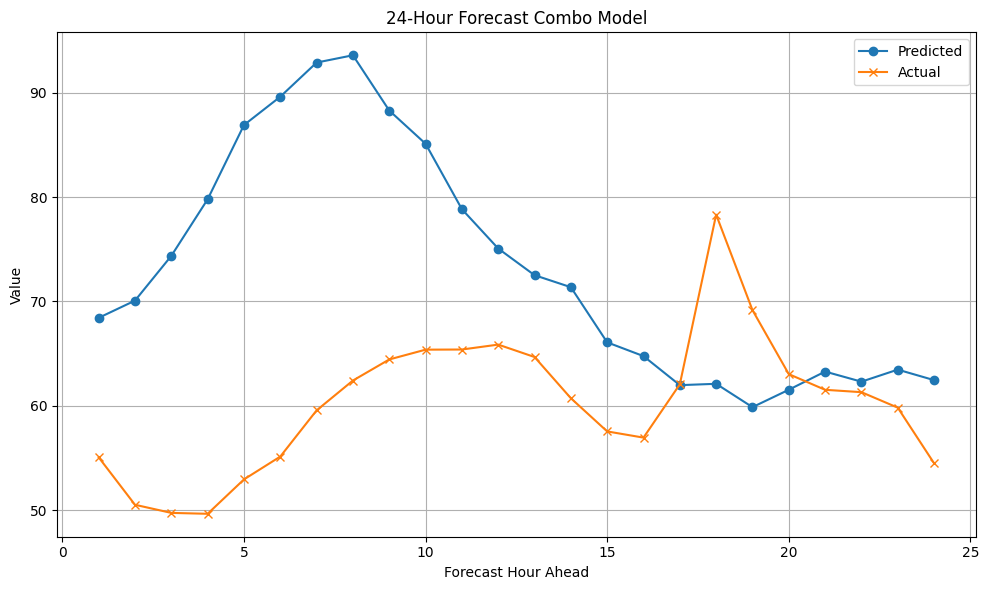

In [21]:
import matplotlib.pyplot as plt

# Get the first row from sl_pred and sl_actual
predicted = sl_pred.iloc[0].values
actual = sl_actual.iloc[0].values

# Plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, 25), predicted, label='Predicted', marker='o')
plt.plot(range(1, 25), actual, label='Actual', marker='x')
plt.title("24-Hour Forecast Combo Model")
plt.xlabel("Forecast Hour Ahead")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
